In [1]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ts = pd.read_excel("data/stock_prices.xlsx", usecols = ["Date", "Adj Close", "Volume"])

In [3]:
# Check for stationarity

In [4]:
result = adfuller(ts["Adj Close"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) # Non-stationary -> need to differentiate

ADF Statistic: -1.522240
p-value: 0.522482


In [5]:
ts["Close_Diff"] = ts["Adj Close"].diff()

In [6]:
result = adfuller(ts["Close_Diff"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) # Stationary

ADF Statistic: -11.104181
p-value: 0.000000


1       0.230000
2      -0.430000
3      -0.030000
4      -0.330000
5       0.200000
         ...    
454     0.769989
455    -2.269989
456    -2.809998
457   -11.910004
458     4.169998
Name: Close_Diff, Length: 458, dtype: float64

/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


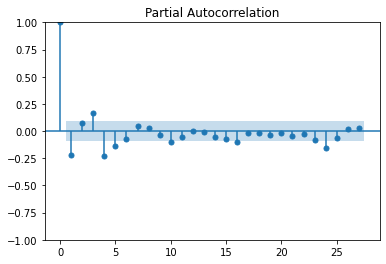

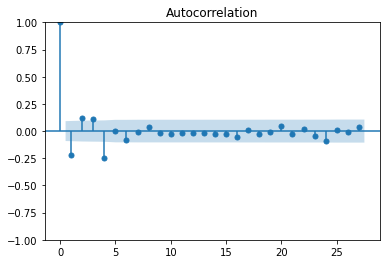

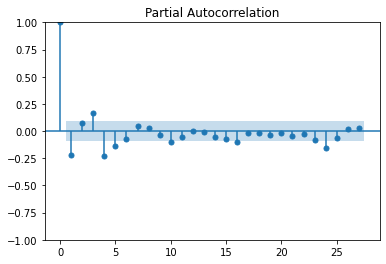

In [14]:
plot_acf(ts.Close_Diff.dropna())
plot_pacf(ts.Close_Diff.dropna())

In [7]:
# Build model and implement rolling window (= ExpandingWindowSplitter) for hyperparameter tuning

In [8]:
# Train, test split
series = ts["Close_Diff"].dropna()
train_size = int(round(len(series) * 0.90, 0))

train = series[:train_size]
y_test = list(series[train_size:])

# Train, val split
train_size2 = int(round(len(train) * 0.90, 0))
y_train = list(train[:train_size2])
y_val = list(train[train_size2:])

In [16]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

def run_rolling_forecast(train, val, params):
    history = [x for x in train]
    predictions = list()
    for t in range(len(val)):
        model = ARIMA(history, order=params)
        model_fit = model.fit(return_params=False)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = val[t]
        history.append(obs)
        # print("%d/%d predicted=%f, expected=%f" % (t, len(val), yhat, obs))
    rmse = mean_squared_error(val, predictions, squared = True)
    mse = mean_squared_error(val, predictions, squared = False)
    mae = mean_absolute_error(val, predictions)

    return rmse, mse, mae, predictions, val

In [156]:
# p: The number of lag observations included in the model, also called the lag order.
# d: The number of times that the raw observations are differenced, also called the degree of differencing.
# q: The size of the moving average window, also called the order of moving average.

para = [(5,0,0), (1,0,1), (2,0,2), (0,0,5), (1,0,0), (0,0,1), (0,0,0)]

In [157]:
history = []
for p in para:
    rmse, mse, mae, _, _ = run_rolling_forecast(y_train, y_val, p)
    s = "Params: " + str(p) + ";RMSE: " + str(rmse) + ";MSE:" + str(mse) + ";MAE:" + str(mae)
    history.append(s)

0/41 predicted=-9.311467, expected=-1.059998
1/41 predicted=4.815049, expected=-7.029999
2/41 predicted=5.741235, expected=-2.800003
3/41 predicted=-8.035018, expected=3.740005
4/41 predicted=-3.391265, expected=-2.369995
5/41 predicted=4.508938, expected=3.259995
6/41 predicted=-0.448058, expected=-9.779999
7/41 predicted=-1.603150, expected=-1.529999
8/41 predicted=-2.972477, expected=-3.270004
9/41 predicted=-3.726472, expected=-8.899994
10/41 predicted=-1.578441, expected=0.720001
11/41 predicted=-5.134909, expected=-0.150009
12/41 predicted=-4.300181, expected=-1.979996
13/41 predicted=0.047606, expected=-9.190002
14/41 predicted=-2.845783, expected=-12.440002
15/41 predicted=-6.406999, expected=-0.799988
16/41 predicted=-7.894794, expected=2.219986
17/41 predicted=-3.904508, expected=4.450012
18/41 predicted=0.246065, expected=17.689987
19/41 predicted=0.216169, expected=-5.369995
20/41 predicted=6.051371, expected=-6.959991
21/41 predicted=2.996522, expected=1.509995
22/41 predi

/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0/41 predicted=-7.287503, expected=-1.059998
1/41 predicted=4.623433, expected=-7.029999
2/41 predicted=9.761109, expected=-2.800003
3/41 predicted=-2.984469, expected=3.740005
4/41 predicted=-4.165346, expected=-2.369995
5/41 predicted=3.334134, expected=3.259995


/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6/41 predicted=1.918371, expected=-9.779999
7/41 predicted=2.444238, expected=-1.529999
8/41 predicted=0.011577, expected=-3.270004
9/41 predicted=-0.694359, expected=-8.899994
10/41 predicted=3.807320, expected=0.720001
11/41 predicted=0.459617, expected=-0.150009
12/41 predicted=0.576828, expected=-1.979996
13/41 predicted=3.836133, expected=-9.190002
14/41 predicted=3.350806, expected=-12.440002
15/41 predicted=1.430975, expected=-0.799988
16/41 predicted=-1.988609, expected=2.219986
17/41 predicted=0.794846, expected=4.450012
18/41 predicted=4.281822, expected=17.689987
19/41 predicted=-0.126790, expected=-5.369995
20/41 predicted=4.667058, expected=-6.959991
21/41 predicted=2.246720, expected=1.509995
22/41 predicted=-6.633220, expected=3.580002
23/41 predicted=-2.089405, expected=-5.400009
24/41 predicted=4.993241, expected=-9.419998
25/41 predicted=2.832595, expected=-4.259995
26/41 predicted=-1.861741, expected=-3.740005
27/41 predicted=0.188135, expected=-3.470001
28/41 predic

In [158]:
# Find best parameters
for item in history:
    print(item)

Params: (5, 1, 0);RMSE: 52.0023748129438;MSE:7.211267212698736;MAE:5.658442127316466
Params: (5, 1, 1);RMSE: 51.98123663786513;MSE:7.209801428462862;MAE:5.778140741560425
Params: (5, 0, 0);RMSE: 52.125588525296315;MSE:7.219805296910459;MAE:5.789548340994598


In [17]:
# Hypothetically now, select best later on
best_param = (5, 1, 1)

In [18]:
y_train_final = y_train + y_val

In [19]:
rmse, mse, mae, y_pred, test = run_rolling_forecast(y_train_final, y_test, best_param)

/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

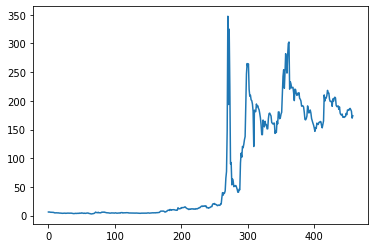

In [32]:
from matplotlib import pyplot
pyplot.plot(ts["Adj Close"])

In [34]:
# Inverse Diff

In [52]:
def diff_inv(series_diff, first_value):
    series_inverted = list(np.r_[first_value, series_diff].cumsum().astype('float64'))
    return series_inverted

In [66]:
plt_test = diff_inv(y_test, ts["Adj Close"][0])
plt_pred = diff_inv(y_pred, ts["Adj Close"][0])

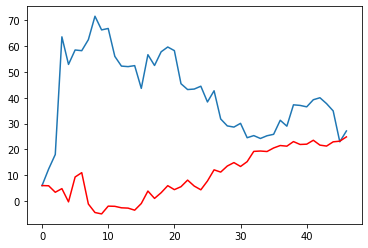

In [68]:
# Plot Price Data
pyplot.plot(plt_test)
pyplot.plot(plt_pred, color = "red")

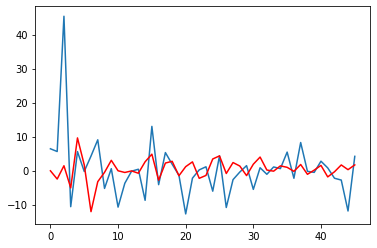

In [69]:
pyplot.plot(y_test)
pyplot.plot(y_pred, color = "red")